In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [47]:
def data_gen(n_cat,n_p):
    n_tot = n_cat*n_p # Total number of datapoints
    centers = np.array([[np.cos(t*2*np.pi/n_cat),np.sin(t*2*np.pi/n_cat)] for t in range(n_cat)]) # Generate centers uniformly around the origin
    data = np.zeros((n_tot,2))
    labels = np.zeros(n_tot)
    for i in range(n_cat):
        scatter = np.random.normal(loc=centers[i],scale=.1, size=(n_p,2))
        data[i*n_p:(i+1)*n_p] = scatter
        labels[i*n_p:(i+1)*n_p] = i
    return centers,data,labels
    
n_categories = 4
n_p = 50 # _per_category
centers,data,labels = data_gen(n_categories,n_p)

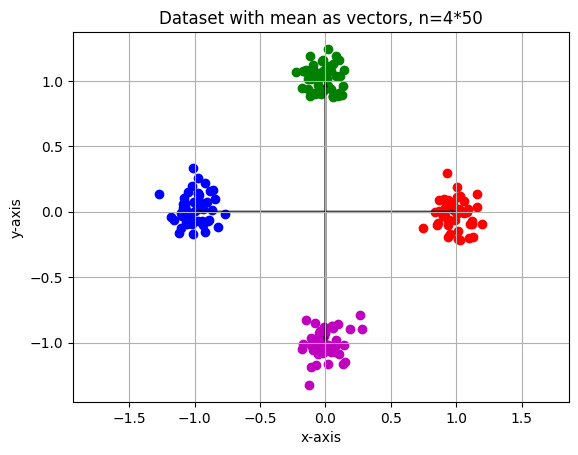

In [48]:
color_atlas = ["r","g","b","m","c","y","orange","brown","lime"]
colors = []
for i in range(n_categories):
    colors.append(color_atlas[i])

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

plt.title(f"Dataset with mean as vectors, n={n_categories}*{n_p}")
plt.axis("equal")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid("on")